<a href="https://colab.research.google.com/github/rohitfarmer/ColabHDStIM/blob/main/ColabHDStIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDStIM: High Dimensional Stimulation Immune Mapping ('HDStIM')

<img src="https://raw.githubusercontent.com/niaid/HDStIM/master/man/figures/sticker.png" height="200" align="right" style="height:200px">

A method for identifying responses to experimental stimulation in mass or flow cytometry that uses high dimensional analysis of measured parameters and can be performed with an end-to-end unsupervised approach.

**Main HDStIM resources:** 
Documentation website: [https://niaid.github.io/HDStIM/](https://niaid.github.io/HDStIM/) 
Source code: [https://github.com/niaid/HDStIM/](https://github.com/niaid/HDStIM/) 
CRAN page: [https://cran.r-project.org/package=HDStIM](https://cran.r-project.org/package=HDStIM)

Note: This notebook is an attempt to make it easier to use HDStIM. However, since it runs on Google Colab, it has its limitations. For example, uploading a large dataset is very slow and may not be straightforward. Also, the marker ranking function that utilizes multiple cores may be orders of magnitude slower than on a local machine with more than two cores. See the more information section at the bottom of the notebook on how to run this notebook locally (recommended).

To report bugs related to ColabHDstIM: [https://github.com/rohitfarmer/ColabHDStIM/issues](https://github.com/rohitfarmer/ColabHDStIM/issues)

In [4]:
#@title 1 Install and load R packages
if(!require(HDStIM)) suppressMessages(install.packages("HDStIM")) 
if(!require(tidyverse)) suppressMessages(install.packages("tidyverse"))   
if(!require(googledrive)) suppressMessages(install.packages("googledrive"))    
if(!require(DT)) suppressMessages(install.packages("DT"))
suppressMessages(library(tidyverse))
suppressMessages(library(googledrive))
suppressMessages(library(HDStIM))
suppressMessages(library(IRdisplay))
suppressMessages(library(DT))

## 2 Example data
HDStIM package comes with an example dataset used for unit testing during CRAN submission. It can also be used as an example of how to format the main single-cell marker expression data frame, and other parameters passed to the main HDStIM function.

In [5]:
#@title 2.1 An example input data frame/tibble for HDStIM
saveRDS(chi11$expr_data, file.path("hdstim-example-data.rds"))
head(chi11$expr_data)

cluster_id,sample_id,condition,patient_id,stim_type,merging1,CD45,CD7,CD19,pPLCg2,⋯,CD16,CD38,CD8,CD45RA,CD3,pERK1_2,HLA_DR,pS6,CD127,ncount
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
79,CHI-011_1_2_A,CHI,CHI-011,A,CD11c CD14 CD38,3.110460,2.601485,0.05114502,0.7158504,⋯,0.09500555,2.3173963,0.2970178,0.1930449,1.78627827,0.04236087,2.7674600,0.0000000,0.3288540,1659
70,CHI-011_1_1_A,CHI,CHI-011,A,CD11c CD14 CD38,3.756624,1.960488,0.00000000,1.5146819,⋯,0.00000000,0.9883232,0.1512892,1.1411799,1.79931812,0.03323656,3.8737299,0.0000000,0.2692525,1659
69,CHI-011_3_10_A,CHI,CHI-011,A,CD11c CD14 CD38,2.911722,1.310564,0.00000000,0.0000000,⋯,0.00000000,1.7305496,0.3464784,0.0000000,1.59753981,0.00000000,1.9176080,0.0000000,0.0000000,1659
69,CHI-011_3_10_A,CHI,CHI-011,A,CD11c CD14 CD38,2.919472,1.376643,0.00000000,0.0000000,⋯,0.00000000,2.5056298,0.0000000,0.0000000,0.02306957,0.00000000,0.5110521,0.5063124,0.0000000,1659
79,CHI-011_4_12_A,CHI,CHI-011,A,CD11c CD14 CD38,2.862431,1.731462,0.00000000,0.6692741,⋯,0.93988490,0.4948810,0.0000000,0.0967478,0.44313860,0.00000000,3.3273032,0.0000000,0.6059084,1659
70,CHI-011_2_6_A,CHI,CHI-011,A,CD11c CD14 CD38,3.554719,2.645969,0.93413488,2.0074880,⋯,0.00000000,0.7568753,0.0000000,0.0639216,1.42091355,0.54579525,4.5526857,0.2791606,0.2860811,1659


In [6]:
#@title 2.2 Examples of other input parameters for HDStIM
cat("State markers:\n")
cat(paste0(chi11$state_markers, colapse = ","))
cat("\n\nCluster col:\n")
cat(chi11$cluster_col)
cat("\n\nStim labels:\n")
cat(paste0(chi11$stim_label, colapse = ","))
cat("\n\nUnstim labels:\n")
cat(chi11$unstim_label)

State markers:
pPLCg2, pSTAT5, AKT, pSTAT1, pP38, pSTAT3, IkBa, pCREB, pERK1_2, pS6,

Cluster col:
merging1

Stim labels:
A, T, L, G,

Unstim labels:
U

## 3 Upload and read data for the analysis
There are multiple ways through which you can upload data into the Colab environment to use with HDStIM.

1. **Preferred:** uploading data to your/temporary Google Drive and downloading the data using the file id in the share link (see more information section at the bottom).
2. **Very very slow:** Using the files tab on the left-hand side and the built-in colab file upload option. However, it is very slow and might only be *useful for small datasets (< 1GB)*.

*Note: if you are using a local runtime, you can read the data directly from your local path.*
 




In [12]:
#@title 3.1 Upload data from a Google Drive
file_id <- "NULL" #@param {type:"string"}
overwrite <- "FALSE" #@param {type:"string"}
if(file_id != "NULL"){
  drive_deauth()
  drive_user()
  public_file <-  drive_get(as_id(file_id))
  drive_download(public_file, overwrite = overwrite)
}


In [9]:
#@title 3.2 Read the uploaded data for HDStIM

file_type = "RDS" #@param ["TSV", "RDS"]
path_to_file = "hdstim-example-data.rds" #@param {type:"string"}
if(file_type == "TSV"){
  data_in <- read_tsv(file.path(path_to_file), 
                      show_col_types = FALSE)
} else if(file_type == "RDS"){
    data_in <- suppressMessages(readRDS(file.path(path_to_file)) %>%
    as_tibble())
}

In [10]:
#@title 3.4 Preview input data (optional)
head(data_in)

cluster_id,sample_id,condition,patient_id,stim_type,merging1,CD45,CD7,CD19,pPLCg2,⋯,CD16,CD38,CD8,CD45RA,CD3,pERK1_2,HLA_DR,pS6,CD127,ncount
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
79,CHI-011_1_2_A,CHI,CHI-011,A,CD11c CD14 CD38,3.110460,2.601485,0.05114502,0.7158504,⋯,0.09500555,2.3173963,0.2970178,0.1930449,1.78627827,0.04236087,2.7674600,0.0000000,0.3288540,1659
70,CHI-011_1_1_A,CHI,CHI-011,A,CD11c CD14 CD38,3.756624,1.960488,0.00000000,1.5146819,⋯,0.00000000,0.9883232,0.1512892,1.1411799,1.79931812,0.03323656,3.8737299,0.0000000,0.2692525,1659
69,CHI-011_3_10_A,CHI,CHI-011,A,CD11c CD14 CD38,2.911722,1.310564,0.00000000,0.0000000,⋯,0.00000000,1.7305496,0.3464784,0.0000000,1.59753981,0.00000000,1.9176080,0.0000000,0.0000000,1659
69,CHI-011_3_10_A,CHI,CHI-011,A,CD11c CD14 CD38,2.919472,1.376643,0.00000000,0.0000000,⋯,0.00000000,2.5056298,0.0000000,0.0000000,0.02306957,0.00000000,0.5110521,0.5063124,0.0000000,1659
79,CHI-011_4_12_A,CHI,CHI-011,A,CD11c CD14 CD38,2.862431,1.731462,0.00000000,0.6692741,⋯,0.93988490,0.4948810,0.0000000,0.0967478,0.44313860,0.00000000,3.3273032,0.0000000,0.6059084,1659
70,CHI-011_2_6_A,CHI,CHI-011,A,CD11c CD14 CD38,3.554719,2.645969,0.93413488,2.0074880,⋯,0.00000000,0.7568753,0.0000000,0.0639216,1.42091355,0.54579525,4.5526857,0.2791606,0.2860811,1659


## 4 HDSTiM

The main HDStIM function requires the following data and parameters.

1. `dat:` A tibble with the single cell data. Cells on rows and markers on columns. Mandatory columns include `condition` (contrast conditions), `stim_type` (labels for stimulants), and a column with cell population names. In addition to marker expression and mandatory columns, other covariates can also be included.  
2. `state_markers:` A character vector with the labels of state markers from the stimulation panel.
3. `cellpop_col:` Column in the tibble with the cell population IDs.
4. `stim_lab:` A character vector of stim label(s). This list should be the same as the stimuli labels in the `stim_type` column.
5. `unstim_lab:` A character vector of unstim label(s). This list should be the same as in the `stim_type` column.
6. `umap:` Boolean (TRUE/FALSE) to carry out UMAP on the selected cells.
7. `umap_cells:` An integer; for calculating UMAPs, take a minimum of `umap_cells` per cluster or the total number of cells if the cluster size is smaller than umap_cells.


In [13]:
#@title 4.1 Input parameters for the main HDStIM function
#expr_data <- data_in #@param {type:"raw"}
state_markers <- "pPLCg2, pSTAT5, AKT, pSTAT1, pP38, pSTAT3, IkBa, pCREB, pERK1_2, pS6" #@param {type:"string"}
state_markers <- stringr::str_replace_all(stringr::str_split(state_markers, ",")[[1]], " ", "")
cluster_col <- "merging1" #@param {type:"string"}
stim_label <- "A, T, L, G" #@param {type:"string"}
stim_label <- stringr::str_replace_all(stringr::str_split(stim_label,",")[[1]], " ", "")
unstim_label <- "U" #@param {type:"string"}
unstim_label <- stringr::str_replace_all(stringr::str_split(unstim_label,",")[[1]], " ", "")
umap <- "TRUE" #@param {type:"string"}
umap_cells <- 1000 #@param {type:"number"}

In [14]:
#@title 4.2 Run HDStIM
remove_input_data_from_memory <- "TRUE" #@param {type:"string"}
mapped_data <-  HDStIM(data_in, state_markers, cluster_col, stim_label,
                       unstim_label, seed_val = 123, 
                       umap = umap, umap_cells = umap_cells, 
                       verbose = FALSE)

if(remove_input_data_from_memory == "TRUE") rm(data_in); ggc <- gc()

In [15]:
#@title 4.3 Responding populations mapped by HDStIM
sig_spc <- dplyr::filter(mapped_data$all_fisher_p_val, p.value < 0.05)
n_sig_spc <- nrow(sig_spc)
resp_add_idx <- sig_spc %>% dplyr::arrange(by = stim_type) %>%
  dplyr::arrange(by = cell_population) %>%
  dplyr::mutate("index" = seq(1, nrow(sig_spc))) %>%
  dplyr::select(index, stim_type, cell_population, p.value)
View(resp_add_idx)



index,stim_type,cell_population,p.value
<int>,<chr>,<chr>,<dbl>
1,A,CD11c CD14 CD38,3.052288e-26
2,G,CD11c CD14 CD38,6.434257e-34
3,L,CD11c CD14 CD38,9.604947e-40
4,T,CD11c CD14 CD38,4.839550e-07
5,A,CD19 CD20 CD45RA HLA-DR CD24,5.555794e-18
6,T,CD19 CD20 CD45RA HLA-DR CD24,7.602217e-03
7,T,CD3 CD4 HLA-DR,3.154513e-04
8,A,CD3 CD8 CD127 CD45RA,1.709727e-24
9,T,CD3 CD8 CD127 CD45RA,9.715599e-32


## 5 HDStIM diagnostic plots

In [27]:
#@title 5.1 Generate and cache all the plots
cat("Generating plots for K-means and Fisher's exact test results.\n")
k_plots <- plot_K_Fisher(mapped_data, path = NULL, verbose = FALSE)
cat("Generating plots for pre and post-HDStIM response marker distribution (very slow).\n")
e_plots <- plot_exprs(mapped_data, path = NULL,verbose = FALSE)
if("umap" %in% names(mapped_data)){
  cat("Generate UMAPs to show responding and non responding cells.")
  u_plots <- plot_umap(mapped_data, path = NULL, verbose = FALSE)
}


Generating plots for K-means and Fisher's exact test results.
Generating plots for pre and post HDStIM response marker distribution (very slow).
Generate UMAPs to show responding and non responding cells.

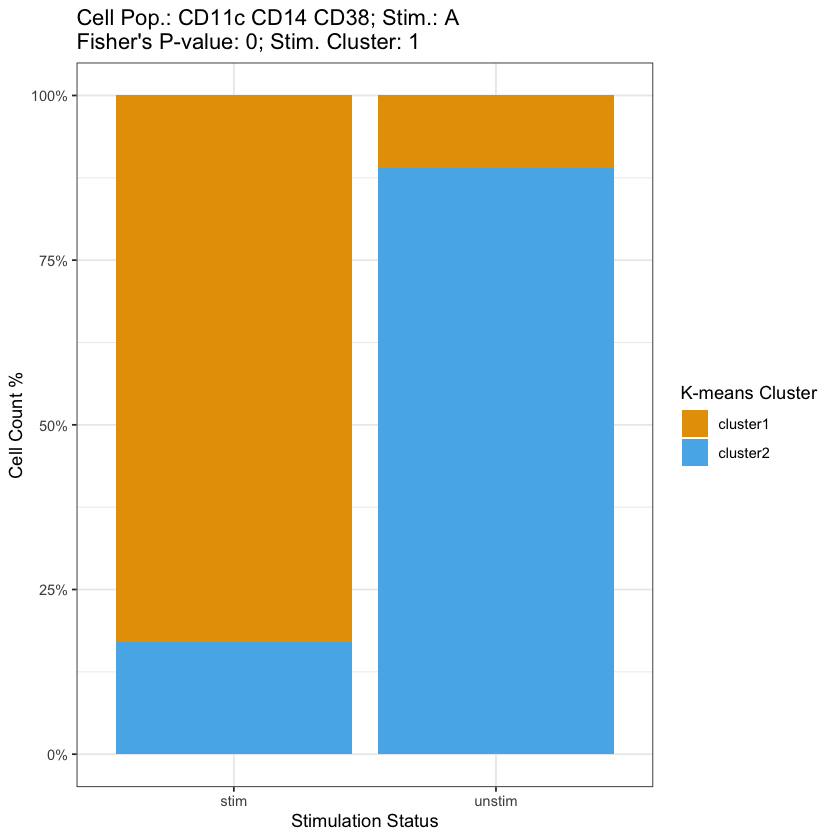

In [24]:
#@title 5.1 Plots to show K-means and Fisher's exact test results
theme_set(theme_bw())
if(n_sig_spc ==0){
    print("Nothing to plot here.")
} else if(n_sig_spc > 0){
  plot_index_no = 1 #@param {type:"integer"}
  if(plot_index_no <= n_sig_spc & plot_index_no > 0){
    k_plots[[plot_index_no]]        
  } else {
      print("The selected value is not in the index.")
  }
}



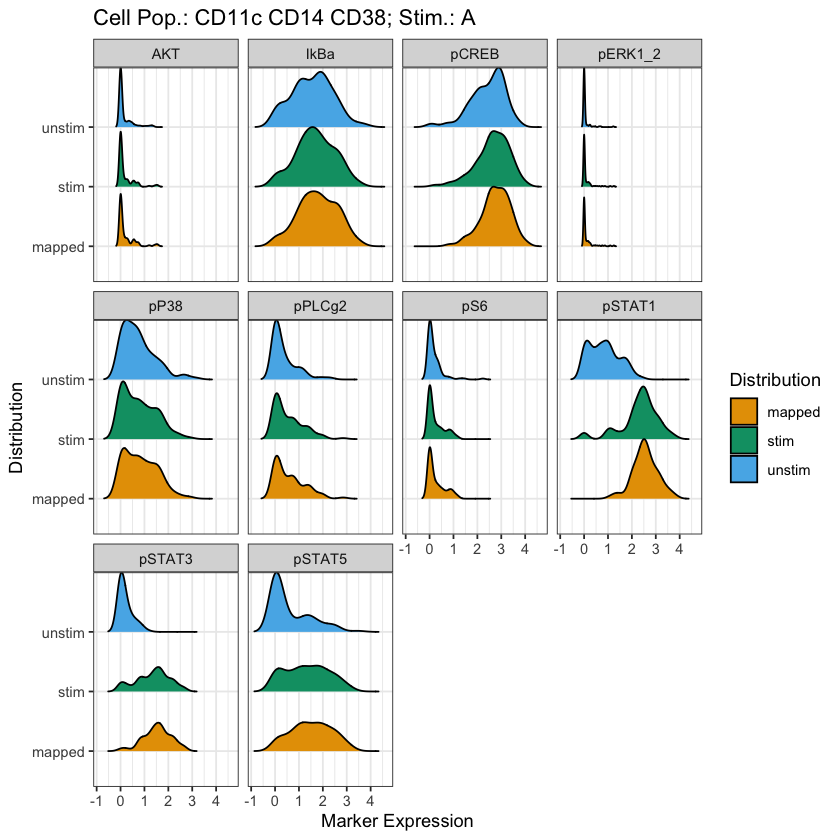

In [26]:
#@title 5.2 Plots to show pre and post-HDStIM response marker distribution
theme_set(theme_bw())
if(n_sig_spc ==0){
    print("Nothing to plot here.")
} else if(n_sig_spc > 0){
plot_index_no = 1 #@param {type:"integer"}
  if(plot_index_no <= n_sig_spc & plot_index_no > 0){
    ep <- e_plots[[plot_index_no]] +
        theme(text = element_text(size = 11))
        suppressMessages(print(ep))
  } else {
      print("The selected value is not in the index.")
  }
}

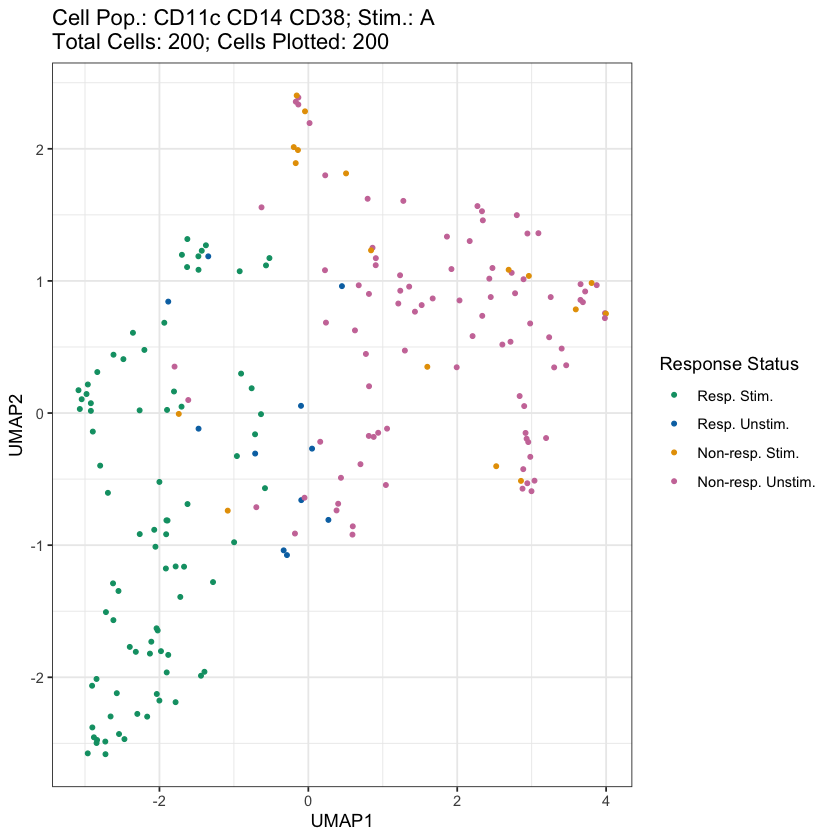

In [29]:
#@title 5.3 Plots to show responding and non-responding cells on a UMAP
theme_set(theme_bw())
if("umap" %in% names(mapped_data)){
  if(n_sig_spc ==0){
      print("Nothing to plot here.")
  } else if(n_sig_spc > 0){
    plot_index_no = 1 #@param {type:"integer"}
    if(plot_index_no <= n_sig_spc & plot_index_no > 0){
      u_plots[[plot_index_no]]        
    } else {
        print("The selected value is not in the index.")
    }
  }    
}else{
    print("Umaps were not generated.")
}


## 6 Rank markers per their contribution to the response

Ranking markers per their contribution to the response through Boruta (random forest) is a time-intensive step, especially when the number of cells in a cell population is large. If many markers are labeled tentative, increase `max_runs` and rerun the function.

1. `n_cells:` Number of cells to downsample the data. The default is NULL to include all the cells.
2. `max_runs:` Maximum number of runs for the random forest algorithm. The default is 100.

In [30]:
#@title 6.1 Run marker ranking
n_cells <- "10000" #@param {type:"string"}
if(n_cells == "NULL"){
    n_cells <- NULL
} else {
    n_cells <- as.integer(n_cells)
}
max_runs <- 100 #@param {type:"integer"}

m_ranks <- marker_ranking_boruta(mapped_data, path = NULL, n_cells = n_cells,
                                 max_runs = max_runs, seed_val = 123,
                                 verbose = 0)

In [31]:
#@title 6.2 Marker ranking stim type and cell population index
m_unique <- m_ranks$attribute_stats %>%
dplyr::select(stim_type, cell_population) %>%
unique() 
View(m_unique %>% dplyr::mutate("index" = seq(1,nrow(m_unique))) %>%
  dplyr::select(index, stim_type, cell_population))

index,stim_type,cell_population
<int>,<chr>,<chr>
1,A,CD11c CD14 CD38
2,A,CD19 CD20 CD45RA HLA-DR CD24
3,A,CD3 CD8 CD127 CD45RA
4,A,CD3 CD8 CD27 CD127
5,T,CD11c CD14 CD38
6,T,CD19 CD20 CD45RA HLA-DR CD24
7,T,CD3 CD4 HLA-DR
8,T,CD3 CD8 CD127 CD45RA
9,L,CD11c CD14 CD38


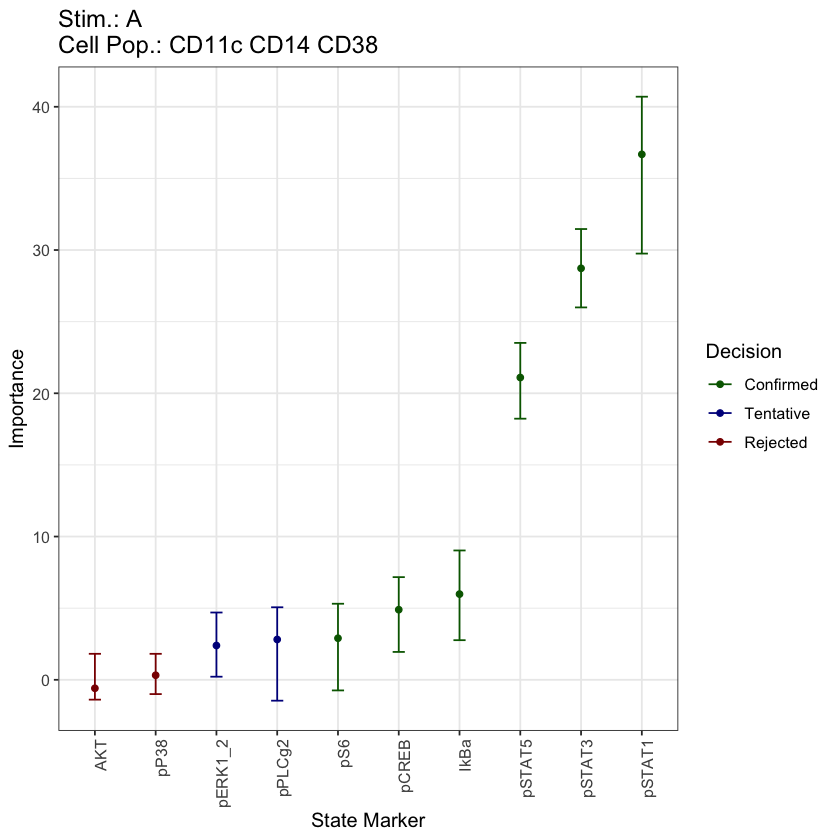

In [32]:
#@title 6.3 Plots to show marker ranking results
theme_set(theme_bw())
if(n_sig_spc ==0){
    print("Nothing to plot here.")
} else if(n_sig_spc > 0){
  plot_index_no = 1 #@param {type:"integer"}
  if(plot_index_no <= n_sig_spc & plot_index_no > 0){
    m_ranks$plots[[plot_index_no]] +
    theme(text = element_text(size = 12))
  } else {
      print("The selected value is not in the index.")
  }
}


## 7 Download analysis results
You can save all the analysis results in your Google Colab instance and then download them individually to your local machine. 


In [33]:
#@title 7.1 Output folder
path_to_output_folder = "hdstim-example-out" #@param {type:"string"}
create_folder = "TRUE" #@param {type:"string"}
if(file.exists(path_to_output_folder)){
    cat("WARNING: Output folder exists. Results will be over written.")
} else{
    if(create_folder == TRUE){
      cat("WARNING: Output folder does not exists. Creating one.")
      dir.create(path_to_output_folder, recursive = TRUE, showWarnings = FALSE)
    } else if((create_folder == FALSE)){
      cat("WARNING: Output folder does not exists. Please one.")
    }
}


In [ ]:
#@title 7.2 Save HDStIM output and diagnostic plots in the output folder
saveRDS(mapped_data, file.path(path_to_output_folder, 
                               "hdstim-main-out.rds"))
write_tsv(mapped_data$all_fisher_p_val, file.path(path_to_output_folder, 
                                                  "all-fisher-data.tsv"))

# HDStIM diagnostic plots
## K Fisher plots
theme_set(theme_grey())
k_plots_path <- file.path(path_to_output_folder, "k-fisher-plots")
#dir.create(k_plots_path, recursive = TRUE, showWarnings = FALSE )
k_plots <- plot_K_Fisher(mapped_data, path = k_plots_path, verbose = FALSE)
### Create tar.gz and delete individual plot files
tar(file.path(path_to_output_folder,"k-fisher-plots.tar.gz")
, files=k_plots_path, compression="gzip")
### Delete original uncompressed files
delete_uncompressed_files_k = "TRUE" #@param {type:"string"}
if(delete_uncompressed_files_k == "TRUE") {
    unlink(k_plots_path, recursive = TRUE)
}

## Pre and post HDStIM maker expression plots
theme_set(theme_grey())
e_plots_path <- file.path(path_to_output_folder, "pre-post-hdstim-expr-plots")
#dir.create(e_plots_path, recursive = TRUE, showWarnings = FALSE )
e_plots <- suppressMessages(plot_exprs(mapped_data, path = e_plots_path,verbose = FALSE))
### Create tar.gz and delete individual plot files
tar(file.path(path_to_output_folder,"pre-post-hdstim-expr-plots.tar.gz")
, files=e_plots_path, compression="gzip")
### Delete original uncompressed files
delete_uncompressed_files_e = "TRUE" #@param {type:"string"}
if(delete_uncompressed_files_e == "TRUE") {
    unlink(e_plots_path, recursive = TRUE)
}

## UMAP if UMAPs are generated during HDStIM
if("umap" %in% names(mapped_data)){
    theme_set(theme_grey())
    u_plots_path <- file.path(path_to_output_folder, "umap-plots")
    #dir.create(u_plots_path, recursive = TRUE, showWarnings = FALSE )
    u_plots <- plot_umap(mapped_data, path = u_plots_path, verbose = FALSE)
    ### Create tar.gz and delete individual plot files
    tar(file.path(path_to_output_folder,"umap-plots.tar.gz")
    , files=u_plots_path, compression="gzip")
    ### Delete original uncompressed files
    delete_uncompressed_files_u = "TRUE" #@param {type:"string"}
    if(delete_uncompressed_files_u == "TRUE") {
      unlink(u_plots_path, recursive = TRUE)
  }
}


In [ ]:
#@title 7.3 Save marker ranking output and plots (if marker ranking was executed)

saveRDS(m_ranks, file.path(path_to_output_folder, 
                           "marker-ranking-main-out.rds"))
write_tsv(m_ranks$attribute_stats, file.path(path_to_output_folder, 
                                             "marker-ranking-attributes-table.tsv"))

# Marker ranking plots
c_s_comb <- m_ranks$attribute_stats %>% dplyr::select(stim_type, cell_population) %>%
dplyr::group_by(, stim_type, cell_population) %>%
ungroup() %>%
unique()

theme_set(theme_grey())
mr_plots_path <- file.path(path_to_output_folder, "marker-ranking-plots")
dir.create(mr_plots_path, recursive = TRUE, showWarnings = FALSE )
for(i in 1:nrow(c_s_comb)){
    att_plot <- m_ranks$plots[[i]]
    stim <- c_s_comb$stim_type[i]
    clust <- c_s_comb$cell_population[i]
    att_file <- paste0("imp_", stim, "_", clust, ".png")
    ggsave(att_file, plot = att_plot, path = mr_plots_path,
           device = "png", dpi = 300, width = 7, height = 6, units = "in")
}

# Create tar.gz and delete individual plot files
tar(file.path(path_to_output_folder,"marker-ranking-plots.tar.gz")
, files=mr_plots_path, compression="gzip")

# Delete original uncompressed files
delete_uncompressed_files = "TRUE" #@param {type:"string"}
if(delete_uncompressed_files == "TRUE") {
    unlink(mr_plots_path, recursive = TRUE)
}


# More information

## Benchmarks/limits
The primary limitation of running HDStIM on Google Colab is the RAM size (12 GB for free). A lack of CPUs will still run the software, albeit slowly. However, if any function hits the RAM limit, the system will crash and restart. This notebook has been tested to run successfully for a dataset with:

* ~ 8 million cells,
* across 24 cell populations,
* and 13 stimulated + 1 unstimulated FCS files for a single donor.

If hitting the RAM limits, run the notebook in a local runtime (see below) or split the data for each stimulant + unstimulated. 

## Running this notebook locally
Google Colab notebooks can run locally (local runtime) on your system while still being hosted on Google servers. Please follow this link on how to setup local runtimes. [https://research.google.com/colaboratory/local-runtimes.html](https://research.google.com/colaboratory/local-runtimes.html)

Once the initial setup is done use the code below to trigger the jupyter notebook for a local runtime.
```
jupyter notebook \
 --NotebookApp.allow_origin='https://colab.research.google.com' \
 --port=8888 \
 --NotebookApp.port_retries=0
```

## How to find file ID from a Google Drive share link
Below is a share link from my Google Drive pointing to the `hdstim-example-data.rds` file.

`https://drive.google.com/file/d/1vj607etanUVYzVFj_HXkznHTd0Ltv_Y4/view?usp=sharing`

This string `1vj607etanUVYzVFj_HXkznHTd0Ltv_Y4` is the **file ID** that we can use to download.